In [1]:
import geopandas
import laspy
from geopandas import GeoDataFrame
import pandas as pd
from shapely.geometry import Point
import numpy as np

In [2]:
# shapefile post correction
filepath = "/var/data/cgaydon/data/202110_building_val/metadata/post_correction_shapefile/Compilation_detections.shp"
gdf = geopandas.read_file(filepath)
candidate_buildings_classes = ["bati_valide", "bati_auto", "surdetection_pont","surdetection_veget", 
"surdetection_vehicule", "surdetection_autre"] 
gdf = gdf[gdf.classe.isin(candidate_buildings_classes)]
gdf = gdf.reset_index().rename(columns={"index":"shape_index"})
print(len(gdf))
gdf.head()

27218


,shape_index,num_classe,_area,classe,geometry
0,0,115,7.0,surdetection_pont,"POLYGON ((791560.895 6271271.950, 791562.787 6..."
1,1,115,11.0,surdetection_pont,"POLYGON ((791806.990 6271517.767, 791809.073 6..."
2,2,115,6.0,surdetection_pont,"POLYGON ((792819.156 6269722.385, 792822.755 6..."
3,3,115,10.0,surdetection_pont,"POLYGON ((792949.676 6270234.185, 792951.278 6..."
4,4,115,6.0,surdetection_pont,"POLYGON ((792186.562 6270516.497, 792187.638 6..."


In [3]:
geopandas.GeoDataFrame(gdf.geometry.values)

,0
0,"POLYGON ((791560.895 6271271.950, 791562.787 6..."
1,"POLYGON ((791806.990 6271517.767, 791809.073 6..."
2,"POLYGON ((792819.156 6269722.385, 792822.755 6..."
3,"POLYGON ((792949.676 6270234.185, 792951.278 6..."
4,"POLYGON ((792186.562 6270516.497, 792187.638 6..."
...,...
27213,"POLYGON ((924608.374 6307696.150, 924608.377 6..."
27214,"POLYGON ((924756.180 6307991.228, 924756.615 6..."
27215,"POLYGON ((924458.609 6307884.459, 924456.106 6..."
27216,"POLYGON ((924061.242 6307064.734, 924058.871 6..."


In [4]:
# A predicted las - we keep only points previously detected as buuildings by terra-solid -> we must say if we agree with
# what generated the shapefile in the first place. This ignore differences in vegetation efficiently, as well building parts
# that were missed.
# Initial classes: [  1,   2,   6 (detected building, no validation),  19 (valid building),  20 (surdetection, unspecified),
#     21 (building, forgotten), 104, 110 (surdetection, vegetation!!), 112 (surdetection, vehicule), 114 (surdetection, others), 115 (surdetection, bridges)]
# las_filepath = "/var/data/cgaydon/data/202110_building_val/logs/runs/2021-10-19/12-07-08/validation_preds/test_876000_6602000.las"
las_filepath = '/var/data/cgaydon/data/202110_building_val/logs/runs/V1_rgb_train_792000_6270000.las'
las = laspy.read(las_filepath)
classification_flag_candidate = [6, 19, 20,110,112,114,115]  # TODO: check what 104 is.
las.points = las[np.isin(las["classification"],classification_flag_candidate)]
# FILTER HEEEEER
las.points = las.points[:10000]
lidar_df = pd.DataFrame(np.array([las.classification,las["BuildingsProba"]]).transpose(), columns=["Classification","BuildingsProba"])
crs = "EPSG:2154"
geometry = [Point(xy) for xy in zip(las.x,las.y)]
lidar_geodf = GeoDataFrame(lidar_df, crs=crs, geometry=geometry)
# ne garder que les aires > 3m²
# Fermeture: buffer positif 1m puis negatif -0.75m
# Douglas-Peucker pour généraliser (1m de tolérance -> c'est haut !)

In [5]:
false_positive = [20, 110,112,114,115]
lidar_geodf["FalsePositive"] = lidar_geodf["Classification"].apply(lambda x: 1 * (x in false_positive))
lidar_geodf.head()

,Classification,BuildingsProba,geometry,FalsePositive
0,19.0,0.0,POINT (792000.000 6269979.860),0
1,110.0,0.0,POINT (792000.000 6269908.890),1
2,19.0,0.0,POINT (792108.630 6269000.000),0
3,19.0,0.0,POINT (792120.660 6269000.000),0
4,19.0,0.0,POINT (792047.970 6269000.000),0


In [11]:
df = lidar_geodf.groupby("Classification")[["BuildingsProba","FalsePositive"]].agg(lambda x: x.to_list())
df

,BuildingsProba,FalsePositive
Classification,,
6.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
19.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
20.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]"
110.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."


In [17]:
df.apply(lambda x: np.sum(x["BuildingsProba"]), axis=1)

Classification
6.0      0.0
19.0     0.0
20.0     0.0
110.0    0.0
dtype: float64

In [1]:
# relier points si <0.5 entre eux -> buffer de 0.25m ?
df = lidar_geodf.copy()
df = df.buffer(0.25)
union = df.unary_union
# ne garder que les aires > 3m²
# Fermeture: buffer positif 1m puis negatif -0.75m
# Douglas-Peucker pour généraliser (1m de tolérance -> c'est haut !)

NameError: name 'lidar_geodf' is not defined

In [46]:
from shapely.ops import unary_union
def fill_holes(shape):
    shape = shape.buffer(0.75)
    shape = unary_union(shape)
    shape = shape.buffer(-0.75)
    return shape

def simplify_shape(shape):
    return shape.simplify(0.1, preserve_topology=False)
    
shapes_no_holes = [fill_holes(shape) for shape in union]
shapes_simplified = [simplify_shape(shape) for shape in shapes_no_holes]

In [56]:
candidate_buildings = geopandas.GeoSeries(shapes_simplified, name="Candidate_Buildings")
candidate_buildings = candidate_buildings[candidate_buildings.area > 3].reset_index(drop=True)
candidate_buildings

0     POLYGON ((792507.341 6269965.268, 792507.553 6...
1     POLYGON ((792492.431 6269964.138, 792492.916 6...
2     POLYGON ((792506.731 6269966.608, 792506.896 6...
3     POLYGON ((792501.881 6269966.238, 792502.093 6...
4     POLYGON ((792487.571 6269964.318, 792487.713 6...
                            ...                        
73    POLYGON ((792053.421 6269997.148, 792054.205 6...
74    POLYGON ((792121.591 6269999.898, 792121.779 6...
75    POLYGON ((792051.961 6269997.838, 792052.061 6...
76    POLYGON ((792049.521 6269999.898, 792049.709 6...
77    POLYGON ((792125.661 6269998.968, 792125.813 6...
Name: Candidate_Buildings, Length: 78, dtype: geometry

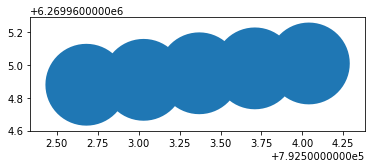

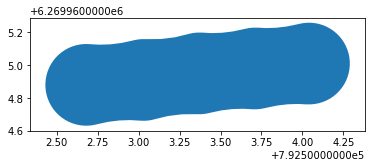

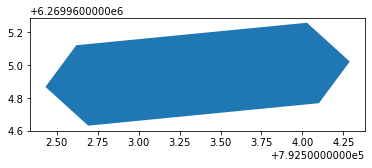

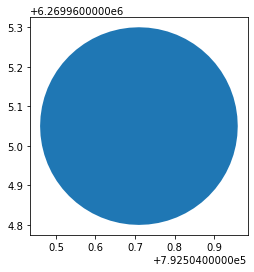

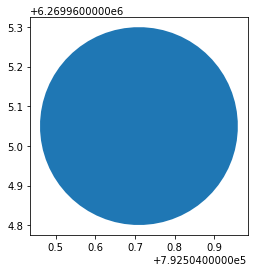

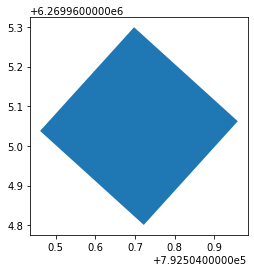

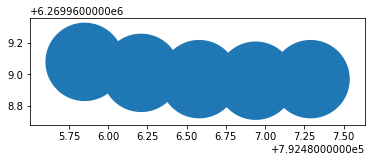

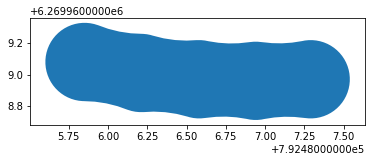

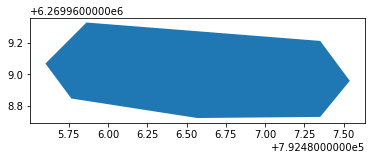

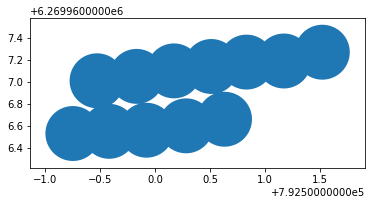

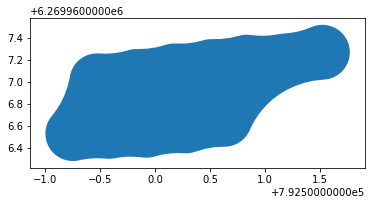

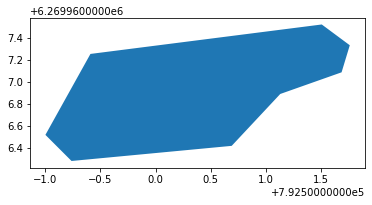

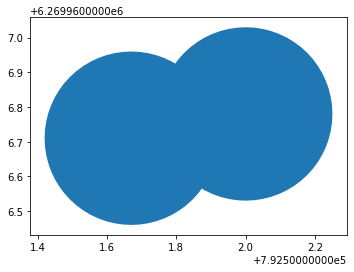

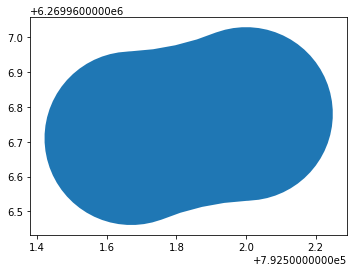

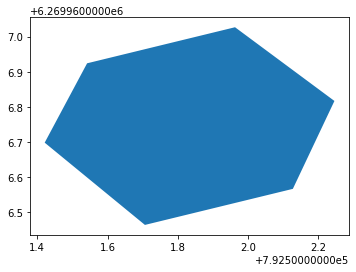

In [48]:
for i in range(10,15):
    geopandas.GeoSeries(union[i]).plot()
    geopandas.GeoSeries(shapes_no_holes[i]).plot()
    geopandas.GeoSeries(shapes_simplified[i]).plot()

In [ ]:
# Keep only points that are within a detected shape
lidar_geodf_inside = lidar_geodf.sjoin(gdf, how="inner", predicate='within')
# Aggregate confusion of points from the same shape in a list
lidar_geodf_inside_lists = lidar_geodf_inside.groupby("shape_index")["BuildingsProba"].agg(lambda x: x.tolist())

In [ ]:
# at the end we have several, independant shape (assume no border effect)
lidar_geodf_inside_lists_all_tiles = pd.concat([lidar_geodf_inside_lists, lidar_geodf_inside_lists])

# Now : calculate % of aggrement for these shape (remember: all points were detected as building by MTS)
def contrast(shape_signals):
    # use a threshold that varies
    arr = np.array(shape_signals)
    arr = np.sum(arr>=.5) / len(arr)
    return arr

lidar_geodf_inside_lists_all_tiles = lidar_geodf_inside_lists_all_tiles.apply(lambda x: contrast(x))
# join back with geometries
df_out = gdf.join(lidar_geodf_inside_lists_all_tiles, on="shape_index",how="left")
# save

In [ ]:
df_out_expl = df_out.dropna()
df_out_expl.explore(column="BuildingsProba", scheme="naturalbreaks", legend=True, k=5)

In [ ]:
# # https://stackoverflow.com/a/66852676/8086033
# # !pip install multiprocesspandas
# from multiprocesspandas import applyparallel
# lidar_df = pd.DataFrame(data = np.array([smaller_las.x, smaller_las.y]).transpose(), columns=["x","y"])
# # lidar_df.applyparallel(lambda x: Point(x),axis=1, num_processes=2)
# %timeit geometry = lidar_df.apply(lambda x: Point(x),axis=1)